# Data Analysis

In this notebook, I analyse the distributions of data in the project. Knowing the distributions of the inputs is important both when finding a classifier and when finding good features.

In [10]:
import h5py
import matplotlib.pyplot as plot
import numpy

CROWDASTRO_H5_PATH = '../crowdastro.h5'

%matplotlib inline

## Stellarity index

The SWIRE data contain a measure of how likely objects are to be stars. We don't want to classify stars (just galaxies) so we need to remove objects above a certain stellarity value. It's not obvious what stellarity value should be our cutoff, though, so we should have a look at the distribution to see if we can gain some insights into the problem.

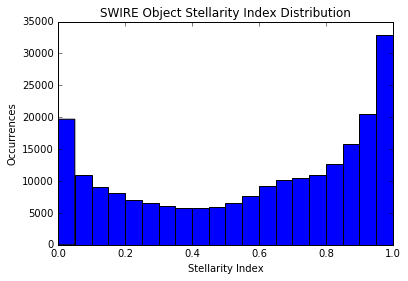

In [16]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    stellarities = f_h5['/swire/cdfs/catalogue'][:, 7]
    plot.title('SWIRE Object Stellarity Index Distribution')
    plot.xlabel('Stellarity Index')
    plot.ylabel('Occurrences')
    plot.hist(stellarities, bins=20)

We can get a slightly more visual feel for the data with a cumulative distribution plot.

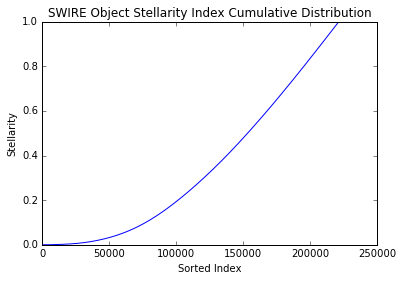

In [54]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    stellarities = f_h5['/swire/cdfs/catalogue'][:, 7]
    plot.title('SWIRE Object Stellarity Index Cumulative Distribution')
    plot.xlabel('Sorted Index')
    plot.ylabel('Stellarity')
    plot.plot(numpy.cumsum(sorted(stellarities)) / sum(stellarities))

## Flux distributions

We want to use the fluxes as inputs to the classifier, so it's useful to know their distribution, too. These have a really unbalanced distribution (probably because of stars) so I'll use a line plot instead of a histogram.

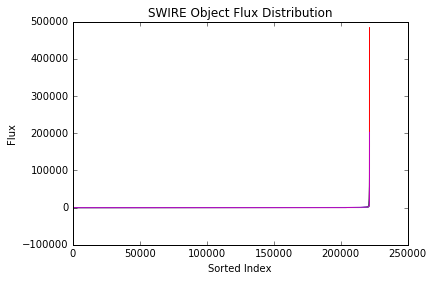

In [29]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Sorted Index')
    plot.ylabel('Flux')
    for band in range(5):
        plot.plot(sorted(fluxes[:, band]))

It looks like we have two levels of flux, here &mdash; ~220000 dim objects, and ~30000 really bright objects. Let's split this up a bit by filtering on high flux.

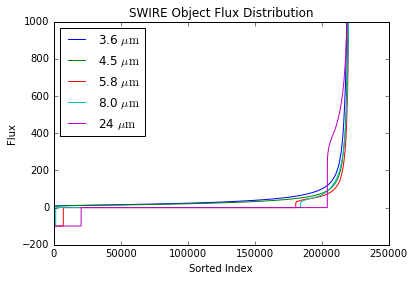

In [43]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Sorted Index')
    plot.ylabel('Flux')
    for band in range(5):
        plot.plot(sorted(fluxes[:, band][fluxes[:, band] < 1000]))
    plot.legend(['3.6 $\mu\mathrm{m}$', '4.5 $\mu\mathrm{m}$', '5.8 $\mu\mathrm{m}$',
                 '8.0 $\mu\mathrm{m}$', '24 $\mu\mathrm{m}$'], loc='upper left')

That's an unusual looking distribution. We can probably make a histogram now.

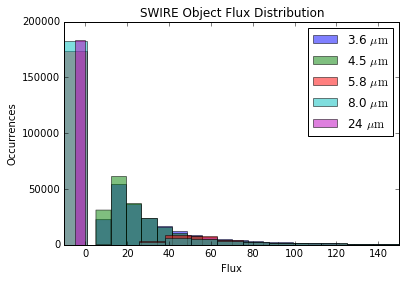

In [66]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Flux')
    plot.ylabel('Occurrences')
    for band in range(5):
        plot.hist(fluxes[:, band][fluxes[:, band] < 150], alpha=0.5, bins=20)
    plot.xlim((-10, 150))
    plot.legend(['3.6 $\mu\mathrm{m}$', '4.5 $\mu\mathrm{m}$', '5.8 $\mu\mathrm{m}$',
                 '8.0 $\mu\mathrm{m}$', '24 $\mu\mathrm{m}$'], loc='upper right')

There are very few fluxes $>150$ so I've cut the plot off there. What about the high end?

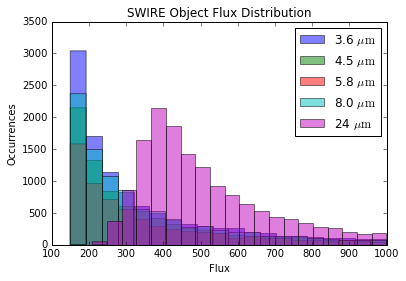

In [71]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Flux')
    plot.ylabel('Occurrences')
    for band in range(5):
        plot.hist(fluxes[:, band][numpy.logical_and(1000 > fluxes[:, band], fluxes[:, band] > 150)], alpha=0.5, bins=20)
    plot.legend(['3.6 $\mu\mathrm{m}$', '4.5 $\mu\mathrm{m}$', '5.8 $\mu\mathrm{m}$',
                 '8.0 $\mu\mathrm{m}$', '24 $\mu\mathrm{m}$'], loc='upper right')

And the *higher* end?

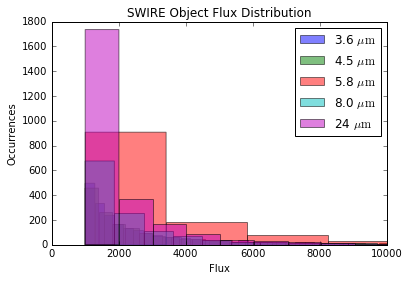

In [77]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Flux')
    plot.ylabel('Occurrences')
    for band in range(5):
        plot.hist(fluxes[:, band][fluxes[:, band] > 1000], alpha=0.5, bins=200)
    plot.xlim((0, 10000))
    plot.legend(['3.6 $\mu\mathrm{m}$', '4.5 $\mu\mathrm{m}$', '5.8 $\mu\mathrm{m}$',
                 '8.0 $\mu\mathrm{m}$', '24 $\mu\mathrm{m}$'], loc='upper right')

There's a handful of outliers at really, really high fluxes. I've cut those off. I think that we could safely cut off the flux at $1000$ or at $150$.